In [1]:
import os
import mokapot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
sys.path
import data_loader as dl

In [2]:
def filter_data(df, prob_column='QValue'):
    #drop decoy
    df = df[df["decoy"]==False]
    #sort by qvalue
    df = df.sort_values(prob_column)
    #drop duplicate scans
    df = df.drop_duplicates(subset=["scan"], keep="first") #keep highest coring
 
    return df

In [3]:
def make_decoy_col_msgf(row):
    if row["Protein"].startswith("XXX_"):
        return False
    else:
        return True
    

In [4]:
def get_PreMokaPot_data(file):
    msg_cleaned_df = dl.clean_msgfplus(file)
    msg_cleaned_df = filter_data(msg_cleaned_df)
    return msg_cleaned_df

In [5]:
#Reading in the data and formatting it for MokaPot
def get_data_for_MokaPot(file):
    msg_df = dl.clean_msgfplus(file)
    #adding target colum for MokaPot
    msg_df["target_column"] = msg_df.apply(make_decoy_col_msgf, axis = 1)
    #sort by qvalue
    msg_df = msg_df.sort_values('QValue')
    #drop duplicate scans
    msg_df = msg_df.drop_duplicates(subset=["scan"], keep="first") #keep highest scoring
    
    msg_df = msg_df.rename(columns = {"scan": "ScanNr"})
    
    #Dropping columns that do not have numerical values
    msg_df = msg_df.drop(columns = {'Protein', 'SpecID', 'FragMethod', 
                                 '#SpecFile', 'Peptide', 'decoy'})
    return msg_df

In [6]:
def plot_qvalues(df, level="psms", threshold=0.01, ax=None, **kwargs):
    qvals = df["probability"]

    ax = plot_qvalues(qvals, threshold=threshold, ax=ax, **kwargs)
    ax.set_xlabel("q-value")
    ax.set_ylabel(f"Accepted {self._level_labs[level]}")

    return ax

In [7]:
def plot_qvalues(qvalues, threshold=0.01, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # Calculate cumulative targets at each q-value
    qvals = pd.Series(qvalues, name="qvalue")
    qvals = qvals.sort_values(ascending=True).to_frame()
    qvals["target"] = 1
    qvals["num"] = qvals["target"].cumsum()
    qvals = qvals.groupby(["qvalue"]).max().reset_index()
    qvals = qvals[["qvalue", "num"]]

    zero = pd.DataFrame({"qvalue": qvals["qvalue"][0], "num": 0}, index=[-1])
    qvals = pd.concat([zero, qvals], sort=True).reset_index(drop=True)

    xmargin = threshold * 0.05
    ymax = qvals.num[qvals["qvalue"] <= (threshold + xmargin)].max()
    ymargin = ymax * 0.05

    # Set margins
    curr_ylims = ax.get_ylim()
    if curr_ylims[1] < ymax + ymargin:
        ax.set_ylim(0 - ymargin, ymax + ymargin)

    ax.set_xlim(0 - xmargin, threshold + xmargin)
    ax.set_xlabel("q-value")
    ax.set_ylabel(f"Discoveries")

    ax.step(qvals["qvalue"].values, qvals.num.values, where="post", **kwargs)

    return ax

In [8]:
#Read all the files into a list here
file_names = ["2ng_rep1", "2ng_rep2", "2ng_rep3", "2ng_rep4", "2ng_rep5", "2ng_rep6",
             "0.2ng_rep1", "0.2ng_rep2", "0.2ng_rep3", "0.2ng_rep4", "0.2ng_rep5", "0.2ng_rep6"]

for file in file_names:
    print(file)

2ng_rep1
2ng_rep2
2ng_rep3
2ng_rep4
2ng_rep5
2ng_rep6
0.2ng_rep1
0.2ng_rep2
0.2ng_rep3
0.2ng_rep4
0.2ng_rep5
0.2ng_rep6


In [9]:
for file in file_names:
    msg_cleaned_df = get_PreMokaPot_data(file)
    msg_df = get_data_for_MokaPot(file)

    msg_for_MP = mokapot.dataset.LinearPsmDataset(msg_df, target_column = "target_column", spectrum_columns = "ScanNr", 
                                                 peptide_column = "peptide", protein_column=None, 
                                                 group_column=None, feature_columns=None, copy_data=True)
    results, models = mokapot.brew(msg_for_MP)
    
    results_df = results.psms
    results_df.to_csv("MokaPot_Output/MsgfPlus/msg_" + file + ".csv")

In [10]:

#Handle all of this below later

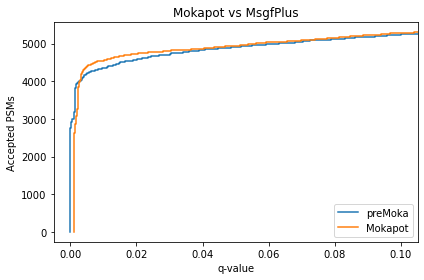

In [11]:
plot_qvalues(msg_cleaned_df["QValue"], label="Pre-mokapot")
plt.title("Mokapot vs MsgfPlus")
results.plot_qvalues(label="mokapot")
plt.legend(["preMoka", "Mokapot"])

plt.tight_layout()

plt.show()

In [12]:
print("The number of PSMs found at or above 0.01: ") 
      
print("\t" + "MsgfPlus: " + str(len(msg_cleaned_df[msg_cleaned_df['QValue'] <= 0.01])))

print("\t""MsgfPlus and MokaPot: " + str(len(results.psms[results.psms['mokapot q-value'] <= 0.01])))

The number of PSMs found at or above 0.01: 
	MsgfPlus: 4345
	MsgfPlus and MokaPot: 4548


In [13]:
msg_df = get_data_for_MokaPot()

msg_df = dl.clean_msgfplus("2ng")
    #adding target colum for MokaPot
msg_df["target_column"] = msg_df.apply(make_decoy_col_msgf, axis = 1)
    #sort by qvalue
msg_df = msg_df.sort_values('QValue')
    #drop duplicate scans
msg_df = msg_df.drop_duplicates(subset=["scan"], keep="first") #keep highest coring
    
    #Dropping columns that do not have numerical values
msg_df = msg_df.drop(columns = {'Protein', 'SpecID', 'FragMethod', 
                                '#SpecFile', 'Peptide', 'decoy', 'QValue', 'PepQValue'})
    
charge_feat = pd.get_dummies(msg_df["Charge"], prefix="Charge")
msg_df = pd.concat([msg_df, charge_feat], axis=1)

msg_for_MP = mokapot.dataset.LinearPsmDataset(msg_df, target_column = "target_column", spectrum_columns = ("scan"),
                                            peptide_column = "peptide", protein_column=None, 
                                            group_column=None, feature_columns= (list(charge_feat.columns) + ["IsotopeError",  
                                            "PrecursorError(ppm)", "DeNovoScore","MSGFScore","SpecEValue"]), copy_data=True)

TypeError: get_data_for_MokaPot() missing 1 required positional argument: 'file'

In [ ]:
results, models = mokapot.brew(msg_for_MP)

In [ ]:
results

In [ ]:
msgDF = get_data_for_MokaPot()
msgDF

In [ ]:
charge_feat = pd.get_dummies(msgDF["Charge"], prefix="Charge")
msgDF = pd.concat([msgDF, charge_feat], axis=1)
msgDF